### aim: 

### date: 

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [3]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

### masks

NameError: name 'xr' is not defined

In [4]:
mm_rg = xr.open_dataset('/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/wspdComponents/PlankTOMmask_krg.nc')
savenam = '/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/wspdComponents/PlankTOMmask_regridrecalc.nc'
mm_rg = xr.open_dataset(savenam)
tmask = mm_rg.tmask

mm_med = xr.open_dataset('/gpfs/data/greenocean/software/resources/MEDUSA/mesh_mask_eORCA1_wrk.nc')
mm_med['area'] = mm_med.tmask[0,:,:] * mm_med.e1t[:,:] * mm_med.e2t[:,:]

mm_tom = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
mm_tom['area'] = mm_tom.tmask[0,0,:,:] * mm_tom.e1t[0,:,:] * mm_tom.e2t[0,:,:]

print(np.nansum(mm_tom.area.values))
print(np.nansum(mm_med.area.values))
print(np.nansum(mm_rg.tmask[:,:].values))

print('ukesm lats')
print(mm_med['nav_lat'][0:114,0])
print('tom lats')
print(mm_tom['nav_lat'][0:37,0])

360890792804973.06
365514208750225.2
378756194791643.8
ukesm lats
<xarray.DataArray 'nav_lat' (y: 114)>
array([-84.21071 , -84.108955, -84.005424, -83.90008 , -83.79289 , -83.68382 ,
       -83.572845, -83.45993 , -83.34504 , -83.22814 , -83.1092  , -82.988174,
       -82.865036, -82.739746, -82.612274, -82.48257 , -82.3506  , -82.21633 ,
       -82.07972 , -81.94073 , -81.79932 , -81.65543 , -81.50905 , -81.360115,
       -81.20859 , -81.05442 , -80.89758 , -80.73801 , -80.57567 , -80.4105  ,
       -80.24247 , -80.071526, -79.89762 , -79.720695, -79.54071 , -79.357605,
       -79.17133 , -78.98184 , -78.78908 , -78.59298 , -78.3935  , -78.19058 ,
       -77.98417 , -77.7742  , -77.56062 , -77.34337 , -77.12238 , -76.89761 ,
       -76.66898 , -76.43644 , -76.19991 , -75.95934 , -75.71467 , -75.46582 ,
       -75.21273 , -74.95534 , -74.693565, -74.42735 , -74.156624, -73.88131 ,
       -73.60134 , -73.31665 , -73.02715 , -72.73279 , -72.43347 , -72.129135,
       -71.8197  , -71.5051

## tom's mldr10_1 and UKESM somxl010 are the same thing, good work on nomenclature everyone

In [5]:
w = xr.open_dataset('/gpfs/data/greenocean/software/runs/TOM12_TJ_1AA3/ORCA2_1m_20120101_20121231_grid_T.nc')
w.somxl030
w.mldr10_1
tmld = w.mldr10_1[0,:,:].values
tmedar = mm_tom['area'].values
print(np.nanmin(tmld[tmedar >0 ]))

10.000015


In [6]:
w = xr.open_dataset('/gpfs/data/greenocean/software/resources/MEDUSA/ukesm_allscen_gridT_mld/nemo_scen_3B_1m_20900101-20900201_grid-T.nc')
tmld = w.somxl010[0,:,:].values
tmedar = mm_med['area'].values

print(np.nanmin(tmld[tmedar >0 ]))

10.5179205


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


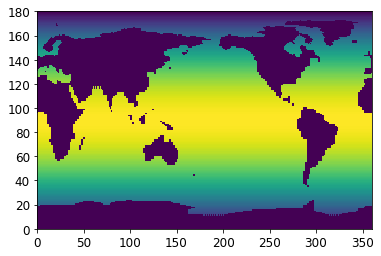

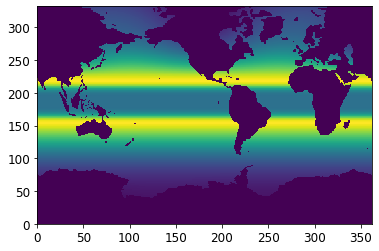

In [7]:
plt.figure()
plt.pcolormesh(mm_rg.tmask[:,:])

plt.figure()
plt.pcolormesh(mm_med.area[:,:])

In [8]:

plt.rc('font', **font)

mod = {
    '1A': {
        'hist_str': 'bc370',
        'fut_str': 'be682',
        'name': 'HIST.OZONE \n LOW TEMP.',
        'name2':'1A: NatlOzone-SSP126',
        'color':'#E8D215',
        'runid':'TOM12_TJ_1AA1'},
    '1B': {
        'hist_str': 'bc370',
        'fut_str': 'ce417',
        'name': 'HIST. OZONE \n HIGH TEMP.',
        'name2':'1B: NatlOzone-SSP370',
        'color':'#87800A',
        'runid':'TOM12_TJ_1BA1'},
    '2A': {
        'hist_str': 'cj198',
        'fut_str': 'cj880',
        'name': 'FIXED OZONE \n LOW TEMP.',
        'name2':'2A: Ozone1950-SSP126',
        'color':'#2DC18E',
        'runid':'TOM12_TJ_2AA1'},
    '2B': {
        'hist_str': 'cj198',
        'fut_str': 'cj881',
        'name': 'FIXED OZONE \n HIGH TEMP.',
        'name2':'2B: Ozone1950-SSP370',
        'color':'#18765C',
        'runid':'TOM12_TJ_2BA1'},
    '3A': {
        'hist_str': 'cj200',
        'fut_str': 'cj484',
        'name': '1990 OZONE \n LOW TEMP.',
        'name2':'3A: Ozone1990-SSP126',
        'color':'#FF462B',
        'runid':'TOM12_TJ_3AA1'},
    '3B': {
        'hist_str': 'cj200',
        'fut_str': 'cj504',
        'name': '1990 OZONE \n HIGH TEMP.',
        'name2':'3B: Ozone1990-SSP370',
        'color':'#822722',
        'runid':'TOM12_TJ_3BA1'},
    'PI': {
        'hist_str': '',
        'fut_str': '',
        'name': 'PI OZONE \n PI TEMP.',
        'name2':'PI: OzonePI-PI',
        'color':'silver',
        'runid':'TOM12_TJ_PIA1'}
}


In [9]:
ex = False
if ex:
    scens = ['1A','1B','2A','2B','3A','3B']

    yr = 1950; yre = 2099

    for s in scens:
        
        times = pd.date_range(f"{yr}/01/01",f"{yre+1}/01/01",freq='MS',closed='left')
        print(len(times))
        savenam = f'./extracted-summary/somxl010_ukesm_{s}.nc'
        ind = 0
        vals = np.zeros(len(times))
        for y in range(yr,yre+1):
            if (y%30 == 0):
                print(y)
            


            tdir = '/gpfs/data/greenocean/software/resources/MEDUSA/ukesm_allscen_gridT_mld/'
            w = xr.open_dataset(f'{tdir}/nemo_scen_{s}_1m_{y}_fy_grid-T.nc')
            tmld = w.sel(y=slice(0,114)).weighted(mm_med['area'].sel(y=slice(0,114))).mean(dim = ['x','y'])
            vals[ind:ind+12] = tmld.somxl010.values
            ind = ind+12


        data_vars = {'somxl010':(['time_counter'], vals,
        {'units': 'm',
        'long_name':'mld by 010 crit'}),
        }
        # define coordinates
        coords = {'time_counter': (['time_counter'], times),
                }
        # define global attributes
        attrs = {'made in':'SOZONE/windAnalyis/oceanFields/MLD.ipynb',
        'desc': ''
        }
        ds = xr.Dataset(data_vars=data_vars,
        coords=coords,
        attrs=attrs)
        ds.to_netcdf(savenam)
        plt.plot(ds.time_counter, ds.somxl010)

In [10]:
ex = False
if ex:
    scens = ['1A','1B','2A','2B','3A','3B']

    yr = 1950; yre = 2099

    for s in range(0,6):
        print(scens[s])
        times = pd.date_range(f"{yr}/01/01",f"{yre+1}/01/01",freq='MS',closed='left')
        print(len(times))
        savenam = f'./extracted-summary/somxl010_tom_{scens[s]}A6.nc'
        ind = 0
        vals = np.zeros(len(times))
        for y in range(yr,yre+1):
            if (y%30 == 0):
                print(y)
            tdir = f'/gpfs/data/greenocean/software/runs/TOM12_TJ_{scens[s]}A6/'
            w = xr.open_dataset(f'{tdir}ORCA2_1m_{y}0101_{y}1231_grid_T.nc')
            tmld = w.mldr10_1.sel(y=slice(0,37)).weighted(mm_tom['area'].sel(y=slice(0,37))).mean(dim = ['x','y'])
            vals[ind:ind+12] = tmld.values
            ind = ind+12


        data_vars = {'somxl010':(['time_counter'], vals,
        {'units': 'm',
        'long_name':'mld by 010 crit'}),
        }
        # define coordinates
        coords = {'time_counter': (['time_counter'], times),
                }
        # define global attributes
        attrs = {'made in':'SOZONE/windAnalyis/oceanFields/MLD.ipynb',
        'desc': ''
        }
        ds = xr.Dataset(data_vars=data_vars,
        coords=coords,
        attrs=attrs)
        ds.to_netcdf(savenam)
        plt.plot(ds.time_counter, ds.somxl010)

In [11]:
ex = False
if ex:
    scens = ['1A','1B','2A','2B','3A','3B']

    yr = 1950; yre = 2099

    for s in range(0,6):
        print(scens[s])
        times = pd.date_range(f"{yr}/01/01",f"{yre+1}/01/01",freq='MS',closed='left')
        print(len(times))
        savenam = f'./extracted-summary/somxl030_tom_{scens[s]}A6.nc'
        ind = 0
        vals = np.zeros(len(times))
        for y in range(yr,yre+1):
            if (y%30 == 0):
                print(y)
            tdir = f'/gpfs/data/greenocean/software/runs/TOM12_TJ_{scens[s]}A6/'
            w = xr.open_dataset(f'{tdir}ORCA2_1m_{y}0101_{y}1231_grid_T.nc')
            tmld = w.somxl030.sel(y=slice(0,37)).weighted(mm_tom['area'].sel(y=slice(0,37))).mean(dim = ['x','y'])
            vals[ind:ind+12] = tmld.values
            ind = ind+12


        data_vars = {'somxl030':(['time_counter'], vals,
        {'units': 'm',
        'long_name':'mld by 030 crit'}),
        }
        # define coordinates
        coords = {'time_counter': (['time_counter'], times),
                }
        # define global attributes
        attrs = {'made in':'SOZONE/windAnalyis/oceanFields/MLD.ipynb',
        'desc': ''
        }
        ds = xr.Dataset(data_vars=data_vars,
        coords=coords,
        attrs=attrs)
        ds.to_netcdf(savenam)
        plt.plot(ds.time_counter, ds.somxl030)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


<Figure size 432x288 with 0 Axes>

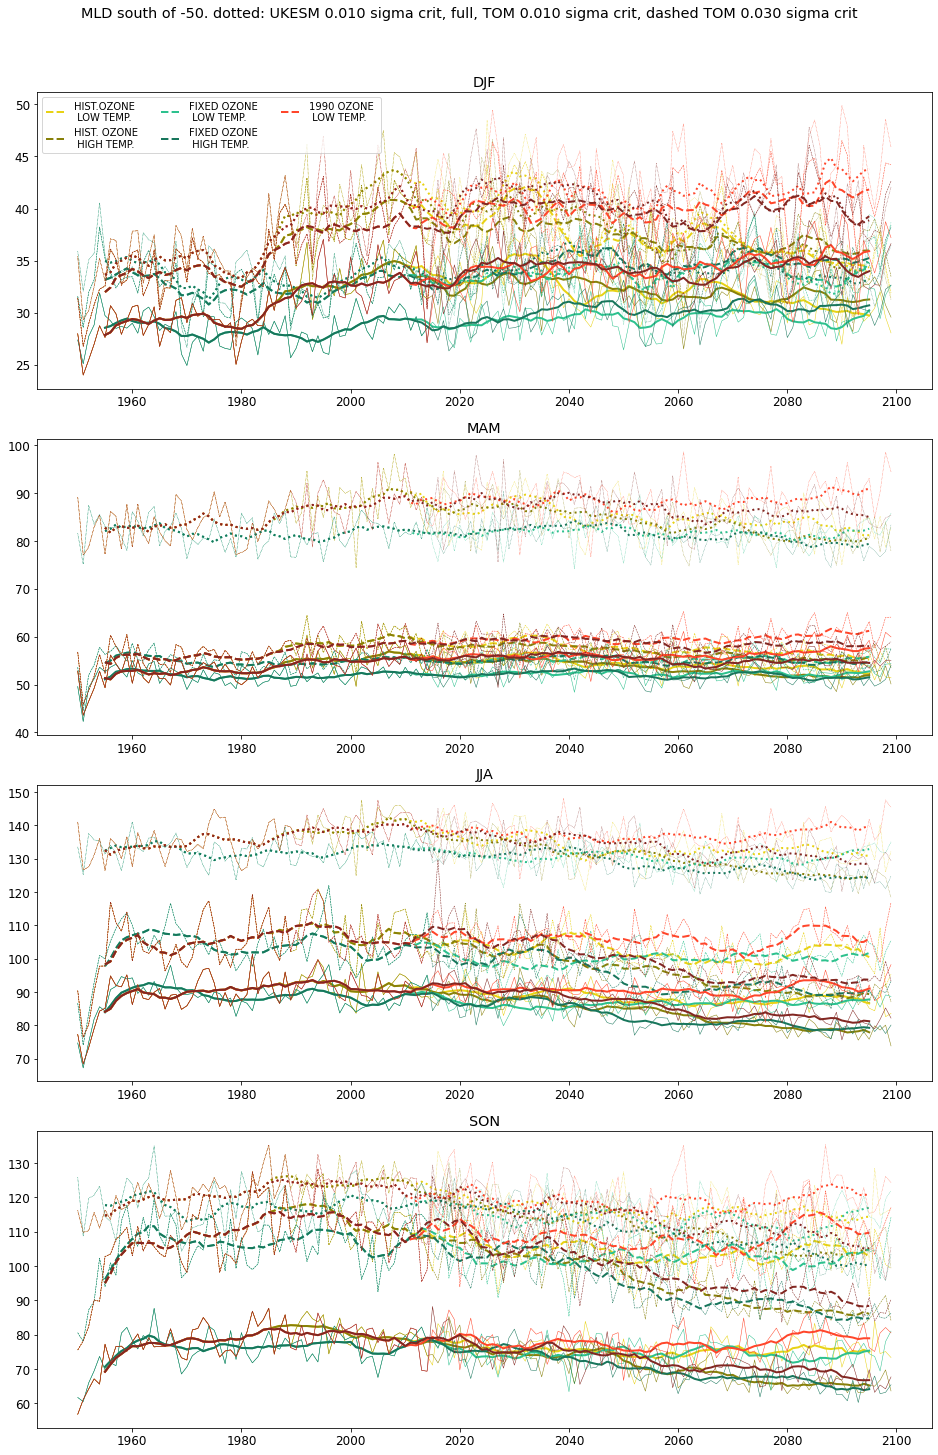

In [12]:
plt.figure()

models = ['1A','1B','2A','2B','3A','3B',\
         ]

seas = ['DJF','MAM','JJA','SON']
    
fact = 1.1
fig, axs = plt.subplots(4,1, figsize=(12*fact, 18*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

for m in range(0,6):#len(models)):
    
    tmod = xr.open_dataset(f'./extracted-summary/somxl010_ukesm_{models[m]}.nc')
    for i in range(0,4):
            tpl = tmod.sel(time_counter=(tmod['time_counter.season'] == seas[i]))
            tv = tpl.groupby('time_counter.year').mean()
            tv_rol = tv.rolling(year=10, center=True).mean()
            axs[i].plot(tv.year,tv.somxl010, color = mod[models[m]]['color'],\
                        linestyle = ':', linewidth = 0.5)            
            axs[i].plot(tv_rol.year,tv_rol.somxl010, color = mod[models[m]]['color'],\
                        linestyle = ':', linewidth = 2)
            axs[0].legend(ncol = 3, fontsize = 10)            
        
    tmod = xr.open_dataset(f'./extracted-summary/somxl010_tom_{models[m]}A6.nc')
    for i in range(0,4):
            tpl = tmod.sel(time_counter=(tmod['time_counter.season'] == seas[i]))
            tv = tpl.groupby('time_counter.year').mean()
            tv_rol = tv.rolling(year=10, center=True).mean()
            axs[i].plot(tv.year,tv.somxl010, color = mod[models[m]]['color'], \
                        linestyle = '-', linewidth = 0.5)            
            axs[i].plot(tv_rol.year,tv_rol.somxl010, color = mod[models[m]]['color'],\
                        linestyle = '-', linewidth = 2)
    
    tmod = xr.open_dataset(f'./extracted-summary/somxl030_tom_{models[m]}A6.nc')
    for i in range(0,4):
            tpl = tmod.sel(time_counter=(tmod['time_counter.season'] == seas[i]))
            tv = tpl.groupby('time_counter.year').mean()
            tv_rol = tv.rolling(year=10, center=True).mean()
            axs[i].plot(tv.year,tv.somxl030, color = mod[models[m]]['color'], \
                        linestyle = '--', linewidth = 0.5)            
            axs[i].plot(tv_rol.year,tv_rol.somxl030, color = mod[models[m]]['color'], label = mod[models[m]]['name'],\
                        linestyle = '--', linewidth = 2)
            
            axs[i].set_title(seas[i])

plt.suptitle('MLD south of -50. dotted: UKESM 0.010 sigma crit, full, TOM 0.010 sigma crit, dashed TOM 0.030 sigma crit', y = 1.02)
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

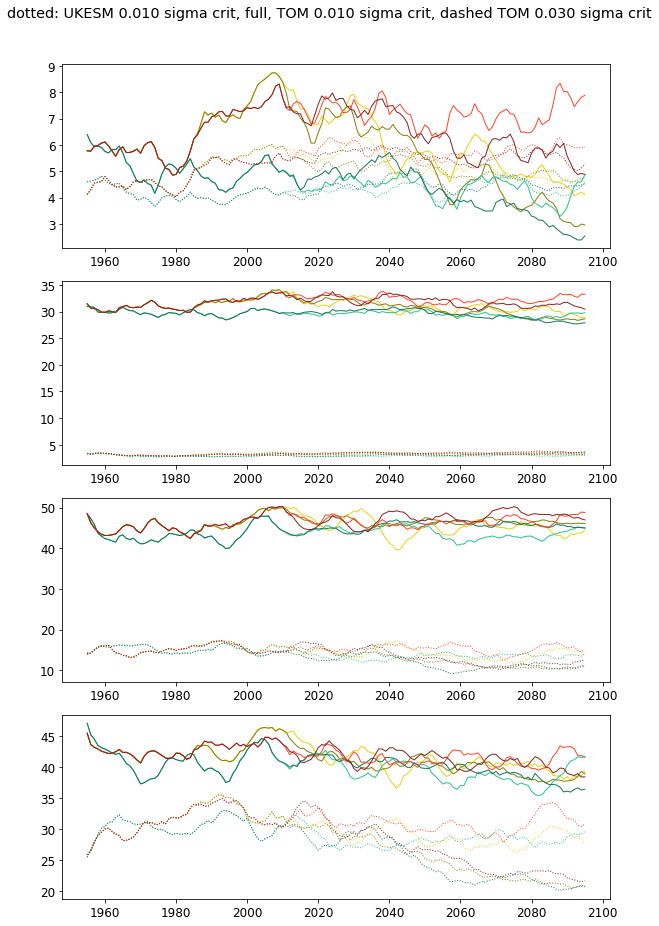

In [13]:
plt.figure()

models = ['1A','1B','2A','2B','3A','3B',\
         ]

seas = ['DJF','MAM','JJA','SON']
    
fact = 0.7
fig, axs = plt.subplots(4,1, figsize=(12*fact, 18*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

for m in range(0,6):#len(models)):
    
    tmod = xr.open_dataset(f'./extracted-summary/somxl010_ukesm_{models[m]}.nc')
    tmod2 = xr.open_dataset(f'./extracted-summary/somxl010_tom_{models[m]}A6.nc')
    tmod3 = xr.open_dataset(f'./extracted-summary/somxl030_tom_{models[m]}A6.nc')
    
    for i in range(0,4):
        tpl = tmod.sel(time_counter=(tmod['time_counter.season'] == seas[i]))
        tv = tpl.groupby('time_counter.year').mean()
        tv_rol = tv.somxl010.rolling(year=10, center=True).mean()

        tpl = tmod2.sel(time_counter=(tmod['time_counter.season'] == seas[i]))
        tv = tpl.groupby('time_counter.year').mean()
        tv_rol2 = tv.somxl010.rolling(year=10, center=True).mean()
        
        tpl = tmod3.sel(time_counter=(tmod['time_counter.season'] == seas[i]))
        tv = tpl.groupby('time_counter.year').mean()
        tv_rol3 = tv.somxl030.rolling(year=10, center=True).mean()       
        
        axs[i].plot(tv_rol.year,(tv_rol-tv_rol2), color = mod[models[m]]['color'],\
            linestyle = '-', linewidth = 1, label = 'UKESM 0.010 - TOM 0.010') 
        axs[i].plot(tv_rol.year,tv_rol3-tv_rol2, color = mod[models[m]]['color'],\
            linestyle = ':', linewidth = 1, label = 'TOM 0.030 - TOM 0.010') 

        
plt.suptitle('dotted: UKESM 0.010 sigma crit, full, TOM 0.010 sigma crit, dashed TOM 0.030 sigma crit', y = 1.02)
plt.tight_layout()

In [14]:
tmod

<xarray.Dataset>
Dimensions:       (time_counter: 1800)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1950-01-01 ... 2099-12-01
Data variables:
    somxl010      (time_counter) float64 ...
Attributes:
    made in:  SOZONE/windAnalyis/oceanFields/MLD.ipynb
    desc:

In [15]:
make = True

if make:
    w = xr.open_dataset('/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/paperFigures/regrid_forcing/TOM12_1960_Cflx.nc')
    tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
    tmesh['csize'] = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]

    data_vars = {'csize':(['y', 'x'], tmesh.csize.values,
    {
    'long_name':'area of cell in m2'}),
    }
    attrs = {'made in':'SOZONE/windAnalyis/wspdComponents/FigMAP-HOV.ipynb',

    }

    tits = np.zeros([12,149,182])
    for i in range(0,12):
        tits[i,:,:] = tmesh.csize.values

    w.Cflx.values = tits
    w['aream2'] = w['Cflx']
    w = w.drop('Cflx')
    w.attrs = attrs
    w.assign(data_vars)
    
    print(np.nansum(w.aream2[0,:,:].values))

    #w.to_netcdf('./PlankTOMmaskKURVA.nc')

#     plt.figure()
#     plt.pcolormesh(w2.aream2[0,:,:])

#     plt.figure()
#     plt.pcolormesh(ylist_ERA_FY.values)

#cdo remapbil,r360x180 PlankTOMmaskKURVA.nc PlankTOMmask_krg.nc

360890792804973.06


In [16]:
print(np.nansum(mm_tom.area.values))
print(np.nansum(mm_med.area.values))

360890792804973.06
365514208750225.2


## regridded map for mld:

In [17]:
def make_yearlist(yrst, yrend, scen):
    yrs = np.arange(yrst,yrend,1)
    ylist = []
    for i in range(0,len(yrs)):
        y = yrs[i]
        tdir = '/gpfs/data/greenocean/software/resources/MEDUSA/ukesm_allscen_gridT_mld/'
        t2 = glob.glob(f'{tdir}/nemo_scen_{scen}_1m_{y}_fy_grid-T-rg.nc')
        ylist.append(t2[0])
    return ylist

ukesm_1A_2015 = xr.open_mfdataset(make_yearlist(2015, 2020, '1A'))
ukesm_1A_2095 = xr.open_mfdataset(make_yearlist(2095, 2100, '1A'))
ukesm_1B_2015 = xr.open_mfdataset(make_yearlist(2015, 2020, '1B'))
ukesm_1B_2095 = xr.open_mfdataset(make_yearlist(2095, 2100, '1B'))


In [18]:
def make_yearlist_tom(yrst, yrend, scen):
    yrs = np.arange(yrst,yrend,1)
    ylist = []
    for i in range(0,len(yrs)):
        y = yrs[i]
        tdir = f'/gpfs/data/greenocean/software/runs/TOM12_TJ_{scen}A6/'
        t2 = glob.glob(f'{tdir}/ORCA2_{y}_mldr10_1-rg.nc')
        ylist.append(t2[0])
    return ylist

tom_1A_2015 = xr.open_mfdataset(make_yearlist_tom(2015, 2020, '1A'))
tom_1A_2095 = xr.open_mfdataset(make_yearlist_tom(2095, 2100, '1A'))
tom_1B_2015 = xr.open_mfdataset(make_yearlist_tom(2015, 2020, '1B'))
tom_1B_2095 = xr.open_mfdataset(make_yearlist_tom(2095, 2100, '1B'))


In [19]:
def plot_southern(fig, ax1, lons, lats, tdat, tvmin, 
                  tvmax, tticks, fs = 12, 
                  tit = '', cbarlab = '', tcmap = 'viridis', lm = True, cbr = True):
   
    ax1.set_extent([-180, 180, -80, -28], ccrs.PlateCarree())
    #make that circle
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax1.set_boundary(circle, transform=ax1.transAxes)
    # lons = nav_lon[0:50,:]; lats = nav_lat[0:50,:]; 
    mesh = ax1.pcolormesh(lons, lats, tdat, cmap = tcmap, vmin = tvmin, vmax = tvmax, 
                     transform=ccrs.PlateCarree())
    
    ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', 
                                                 edgecolor='face', facecolor='k'))

    ax1.set_title(tit, fontsize = fs)
    cb = 0
    if cbr:
        cb = fig.colorbar(mesh, ax = ax1, orientation = 'horizontal',
                     pad = 0.06, fraction = 0.045, shrink = 0.9)
        cb.set_label(label=cbarlab,fontsize = 8)
        cb.set_ticks(tticks, fontsize = 80)
        cb.ax.tick_params(labelsize=8)
    return cb


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


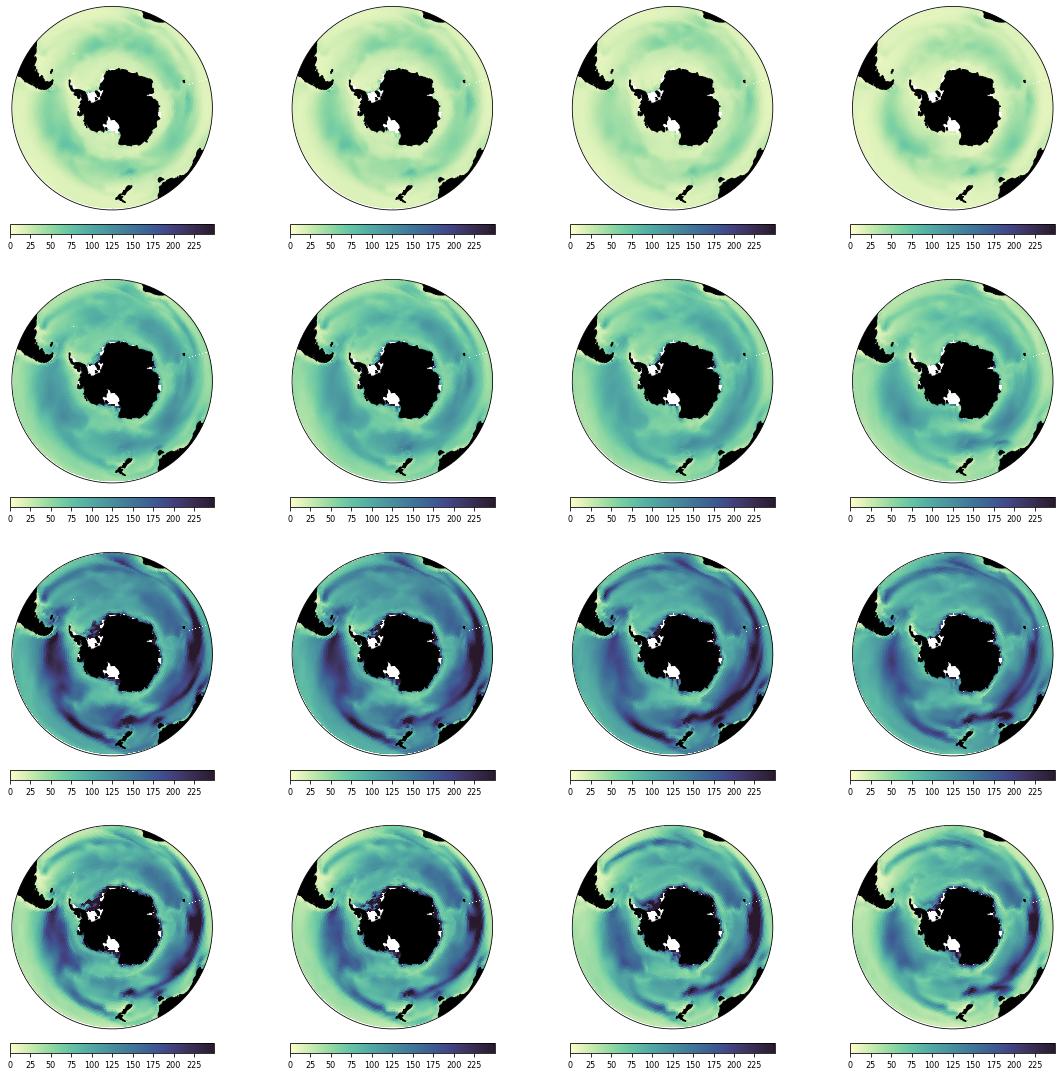

In [20]:
fact = 0.25
fig = plt.figure(figsize=[77*fact, 77*fact])
tvmin = 0; tvmax = 250
tticks = np.arange(tvmin,tvmax,25)
ind = 0; seas = 'full year'

scens = [ukesm_1A_2015, ukesm_1B_2015, \
         ukesm_1A_2095,  ukesm_1B_2095,]


# titsc = ['Preind', 'Fixed Ozone  \n Low Temp', 'Hist. Ozone, \n Low Temp', '1990 Ozone \n Low Temp',\
#          'Fixed Ozone \n High Temp', 'Hist. Ozone \n High Temp', '1990 Ozone \n High Temp']

seas = ['DJF', 'MAM', 'JJA', 'SON']

lats = ukesm_1A_2015.lat.isel(lat=slice(0,60))
lons = ukesm_1A_2015.lon

# tvmin =

ind = 1
for s in range(0,4):
    for sc in range(0,4):
        tscen = scens[sc]
        ax1 = fig.add_subplot(4, 4, ind, projection=ccrs.Orthographic(0, -90))
        tdat = tscen.somxl010.sel(time_counter= tscen['time_counter.season'] == seas[s])\
            .isel(lat=slice(0,60)).mean(dim = 'time_counter').values
        plot_southern(fig, ax1, lons, lats, tdat, tvmin, 
                  tvmax, tticks, fs = 12, 
                  tit = '', cbarlab = '', tcmap = cm.deep, lm = True, cbr = True)
        #plot_mk_with_sigmask(fig, ax1, scen.mk_slope[s,:,:], scen.mk_p[s,:,:], tmi, tma)
#         tit = f'{titsc[sc]} {seas[s]}'
#         ax1.set_title(tit)
        ind = ind+1

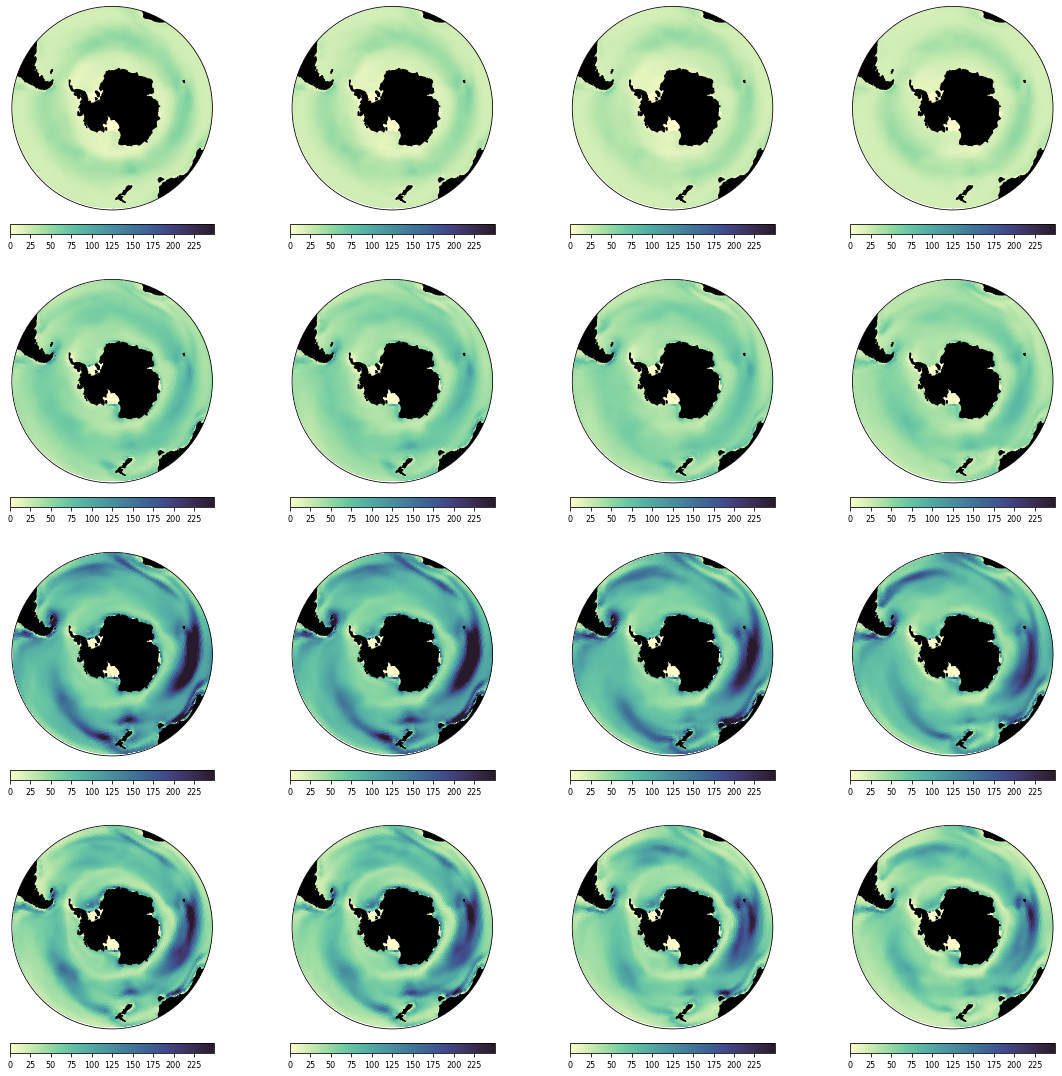

In [21]:
fact = 0.25
fig = plt.figure(figsize=[77*fact, 77*fact])
tvmin = 0; tvmax = 250
tticks = np.arange(tvmin,tvmax,25)
ind = 0; seas = 'full year'

scens = [tom_1A_2015, tom_1B_2015, \
         tom_1A_2095,  tom_1B_2095,]


# titsc = ['Preind', 'Fixed Ozone  \n Low Temp', 'Hist. Ozone, \n Low Temp', '1990 Ozone \n Low Temp',\
#          'Fixed Ozone \n High Temp', 'Hist. Ozone \n High Temp', '1990 Ozone \n High Temp']

seas = ['DJF', 'MAM', 'JJA', 'SON']

lats = tom_1A_2015.lat.isel(lat=slice(0,60))
lons = tom_1A_2015.lon

# tvmin =

ind = 1
for s in range(0,4):
    for sc in range(0,4):
        tscen = scens[sc]
        ax1 = fig.add_subplot(4, 4, ind, projection=ccrs.Orthographic(0, -90))
        tdat = tscen.mldr10_1.sel(time_counter= tscen['time_counter.season'] == seas[s])\
            .isel(lat=slice(0,60)).mean(dim = 'time_counter').values
        plot_southern(fig, ax1, lons, lats, tdat, tvmin, 
                  tvmax, tticks, fs = 12, 
                  tit = '', cbarlab = '', tcmap = cm.deep, lm = True, cbr = True)
        #plot_mk_with_sigmask(fig, ax1, scen.mk_slope[s,:,:], scen.mk_p[s,:,:], tmi, tma)
#         tit = f'{titsc[sc]} {seas[s]}'
#         ax1.set_title(tit)
        ind = ind+1

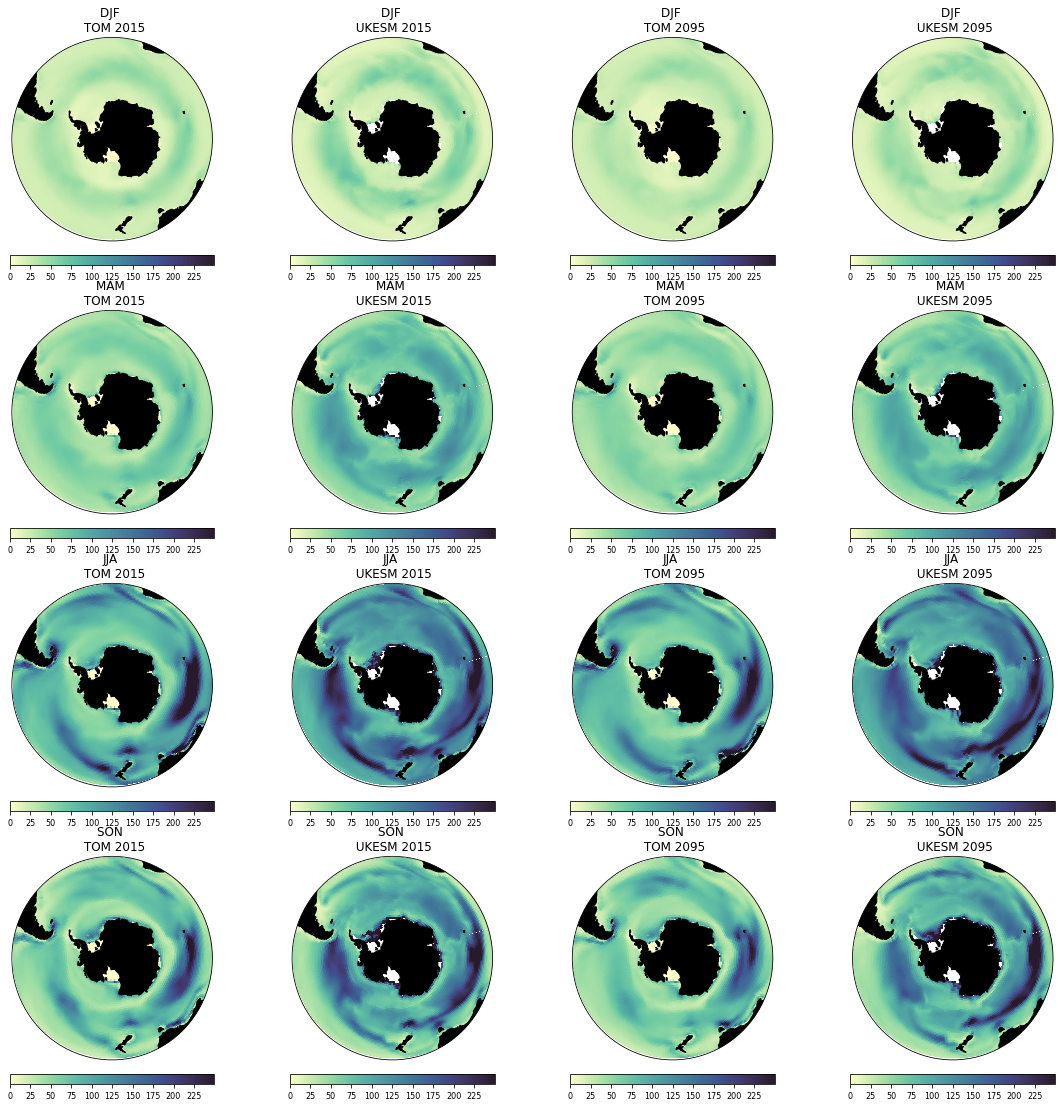

In [22]:
fact = 0.25
fig = plt.figure(figsize=[77*fact, 77*fact])
tvmin = 0; tvmax = 250
tticks = np.arange(tvmin,tvmax,25)
ind = 0; seas = 'full year'

scens = [tom_1A_2015, ukesm_1A_2015, \
         tom_1A_2095,  ukesm_1A_2095,]


# titsc = ['Preind', 'Fixed Ozone  \n Low Temp', 'Hist. Ozone, \n Low Temp', '1990 Ozone \n Low Temp',\
#          'Fixed Ozone \n High Temp', 'Hist. Ozone \n High Temp', '1990 Ozone \n High Temp']

seas = ['DJF', 'MAM', 'JJA', 'SON']
sct = ['TOM 2015', 'UKESM 2015', 'TOM 2095', 'UKESM 2095']


lats = tom_1A_2015.lat.isel(lat=slice(0,60))
lons = tom_1A_2015.lon

# tvmin =

ind = 1
for s in range(0,4):
    for sc in range(0,4):
        tscen = scens[sc]
         
        if 'TOM' in sct[sc]:
            tfield = 'mldr10_1'
        else:
            tfield = 'somxl010'
        
        
        ax1 = fig.add_subplot(4, 4, ind, projection=ccrs.Orthographic(0, -90))
        tdat = tscen[tfield].sel(time_counter= tscen['time_counter.season'] == seas[s])\
            .isel(lat=slice(0,60)).mean(dim = 'time_counter').values
        ttit = f'{seas[s]} \n {sct[sc]}'
        plot_southern(fig, ax1, lons, lats, tdat, tvmin, 
                  tvmax, tticks, fs = 12, 
                  tit = ttit, cbarlab = '', tcmap = cm.deep, lm = True, cbr = True)



        ind = ind+1

why deeper mld?

In [23]:
tom_ptrc = xr.open_dataset('/gpfs/data/greenocean/software/runs//TOM12_TJ_1AA6/ORCA2_1m_19550101_19551231_grid_T.nc')
ukesm_ptrc = xr.open_dataset('/gpfs/data/greenocean/software/resources/MEDUSA/ukesm_allscen_gridT_TS/nemo_scen_1A_1m_1955_fy_grid-T.nc')

In [24]:
tplt = ukesm_ptrc.thetao.isel(time_counter=0).isel(y=slice(0,114))# .mean(dim = ['y','x']).values
tplt

<xarray.DataArray 'thetao' (deptht: 75, y: 114, x: 362)>
[3095100 values with dtype=float64]
Coordinates:
    time_counter  datetime64[ns] 1955-01-15
  * deptht        (deptht) float32 0.50576 1.5558553 ... 5698.0605 5902.0576
    nav_lon       (y, x) float32 ...
    nav_lat       (y, x) float32 ...
Dimensions without coordinates: y, x
Attributes:
    units:      degC
    long_name:  Sea Water Potential Temperature

Text(0.5, 0.98, 'year 1955 T and S south of -50 (not area-weighted)')

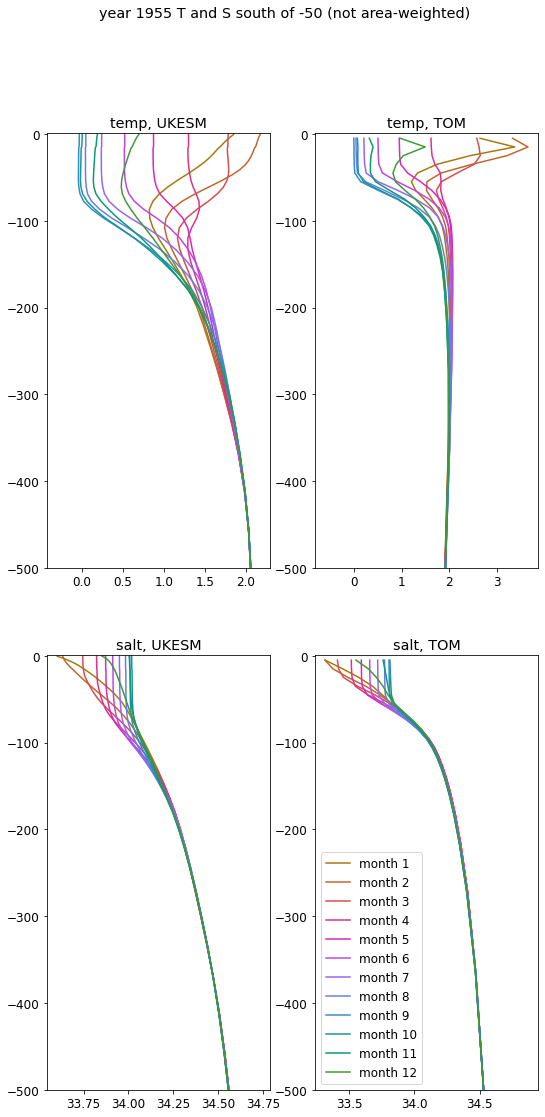

In [25]:
tcm = cm.phase

fact = 1.1
fig, axs = plt.subplots(2,2, figsize=(8*fact, 16*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i in range(0,12):
    tplt = ukesm_ptrc.isel(time_counter=i).isel(y=slice(0,114)).mean(dim = ['y','x'])
    axs[0].plot(tplt.thetao,-tplt.deptht, color = tcm(1.*(i)/13), label = f'month {i+1}')
    
for i in range(0,12):
    tplt = tom_ptrc.votemper.isel(time_counter=i).isel(y=slice(0,37)).values#.mean(dim = ['y','x'])
    tplt[tplt == 0] = np.nan
    tvl = np.zeros(31)
    for d in range(0,31):
        tvl[d] = np.nanmean(tplt[d,:,:])
    axs[1].plot(tvl,-tom_ptrc.deptht, color = tcm(1.*(i)/13), label = f'month {i+1}')
    
    axs[0].set_ylim([-500,1])
    axs[1].set_ylim([-500,1])


for i in range(0,12):
    tplt = ukesm_ptrc.isel(time_counter=i).isel(y=slice(0,114)).mean(dim = ['y','x'])
    axs[2].plot(tplt.so,-tplt.deptht, color = tcm(1.*(i)/13), label = f'month {i+1}')
    
for i in range(0,12):
    tplt = tom_ptrc.vosaline.isel(time_counter=i).isel(y=slice(0,37)).values#.mean(dim = ['y','x'])
    tplt[tplt == 0] = np.nan
    tvl = np.zeros(31)
    for d in range(0,31):
        tvl[d] = np.nanmean(tplt[d,:,:])
    axs[3].plot(tvl,-tom_ptrc.deptht, color = tcm(1.*(i)/13), label = f'month {i+1}')
    
    axs[2].set_ylim([-500,1])
    axs[3].set_ylim([-500,1])
    
    axs[3].legend(ncol =1, loc = 'best')
#     axs[0].set_ylim([-1000,1])
#     axs[1].set_ylim([-1000,1])

tits = ['temp, UKESM', 'temp, TOM', 'salt, UKESM', 'salt, TOM']

for i in range(0,4):
    axs[i].set_title(tits[i])#(ncol =1, loc = 'best')
    
plt.suptitle('year 1955 T and S south of -50 (not area-weighted)')

In [26]:
tplt

array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [33.86041 , 33.888657, 33.92761 , ..., 33.891544, 33.86041 ,
         33.888657],
        [33.96386 , 34.01347 , 34.054024, ..., 33.957275, 33.96386 ,
         34.01347 ],
        [34.134277, 34.181152, 34.212627, ..., 34.0943  , 34.134277,
         34.181152]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [33.8605  , 33.888752, 33.92774 , ..., 33.891647, 33.8605  ,
         33.888752],
        [33.96395 , 34.013786, 34.054676, ..., 33.957355, 33.96395 ,
   

In [27]:
ukesm_ptrc.thetao.isel(y=slice(100,110)).isel(x=slice(0,10)).isel(deptht=slice(0,1)).isel(time_counter=slice(0,1)).values

array([[[[1.08210671, 0.71992886, 0.61112928, 0.57370687, 0.63498563,
          0.8779766 , 1.01659477, 1.0006758 , 0.98570186, 1.03566027],
         [1.2074858 , 0.9365229 , 0.79592067, 0.75251478, 0.76433724,
          0.9326697 , 1.11650789, 1.17486966, 1.20289385, 1.27585363],
         [1.56527317, 1.37831771, 1.19780946, 1.11570823, 1.05802155,
          1.14519465, 1.26928508, 1.31822193, 1.36774302, 1.48432457],
         [2.12935638, 1.98460639, 1.77005827, 1.59045029, 1.41702056,
          1.3170836 , 1.35622466, 1.4072299 , 1.47982204, 1.59156728],
         [2.63990736, 2.54706025, 2.35295844, 2.09387326, 1.78987539,
          1.5579952 , 1.50358319, 1.54110837, 1.62148213, 1.708987  ],
         [3.08654761, 2.99062514, 2.82462835, 2.50310874, 2.08236623,
          1.81319165, 1.7042141 , 1.72976375, 1.79570448, 1.8379097 ],
         [3.44261718, 3.34181833, 3.19775772, 2.93344378, 2.46712065,
          2.09091592, 1.90659797, 1.9027698 , 1.93872285, 1.95248139],
         [3.7

In [28]:
mm_med = xr.open_dataset('/gpfs/data/greenocean/software/resources/MEDUSA/mesh_mask_eORCA1_wrk.nc')
mm_med['area'] = mm_med.tmask[0,:,:] * mm_med.e1t[:,:] * mm_med.e2t[:,:]

mm_tom = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
mm_tom['area'] = mm_tom.tmask[0,0,:,:] * mm_tom.e1t[0,:,:] * mm_tom.e2t[0,:,:]

### lol

In [29]:
def make_yearlist_uk(yrst, yrend, scen):
    yrs = np.arange(yrst,yrend,1)
    ylist = []
    for i in range(0,len(yrs)):
        y = yrs[i]
        tdir = '/gpfs/data/greenocean/software/resources/MEDUSA/ukesm_allscen_gridT_mld/'
        t2 = glob.glob(f'{tdir}/nemo_scen_{scen}_1m_{y}_fy_grid-T.nc')
        ylist.append(t2[0])
    return ylist

def make_yearlist_tom(yrst, yrend, scen, dir1 = '/gpfs/data/greenocean/software/runs/'):
    yrs = np.arange(yrst,yrend,1)
    ylist = []
    for i in range(0,len(yrs)):
        y = yrs[i]
        tdir = f'{dir1}{scen}/'
        t2 = glob.glob(f'{tdir}/ORCA2_1m_{y}0101_{y}1231_grid_T.nc')
        ylist.append(t2[0])
    return ylist

ukesm_mld = xr.open_mfdataset(make_yearlist_uk(2001, 2007, '1A'))
TJ_1AA6_mld = xr.open_mfdataset(make_yearlist_tom(2001, 2007, 'TOM12_TJ_1AA6'))
TJ_1ASA_mld = xr.open_mfdataset(make_yearlist_tom(2001, 2007, 'TOM12_TJ_1ASA'))
ET_SI73_mld = xr.open_mfdataset(make_yearlist_tom(2001, 2007, 'TOM12_ET_SI73', dir1 = '/gpfs/home/e031/scratch/'))

In [30]:
test = ET_SI73_mld.somxl030.groupby('time_counter.month').mean().sel(y = slice(22,50))


In [31]:
test

<xarray.DataArray 'somxl030' (month: 12, y: 28, x: 182)>
dask.array<getitem, shape=(12, 28, 182), dtype=float32, chunksize=(1, 28, 182), chunktype=numpy.ndarray>
Coordinates:
    nav_lat  (y, x) float32 dask.array<chunksize=(28, 182), meta=np.ndarray>
    nav_lon  (y, x) float32 dask.array<chunksize=(28, 182), meta=np.ndarray>
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: y, x

In [32]:
tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
tmesh['csize'] = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]
csize_broad = np.zeros([31,149,182])
for i in range(0,31):
    csize_broad[i,:,:] = tmesh['csize'].values
cvol = csize_broad * tmesh['e3t_0'][0,:,:,:] * tmesh['tmask'][0,:,:,:]

In [33]:
tmesh.nav_lat[22:50,101]

<xarray.DataArray 'nav_lat' (y: 28)>
array([-64.867195, -64.00423 , -63.113754, -62.195126, -61.247692, -60.27082 ,
       -59.263885, -58.226284, -57.15743 , -56.05677 , -54.923775, -53.75795 ,
       -52.558838, -51.326035, -50.059177, -48.757957, -47.422142, -46.051548,
       -44.646076, -43.20571 , -41.73051 , -40.220642, -38.67636 , -37.09803 ,
       -35.48612 , -33.84122 , -32.16404 , -30.455408], dtype=float32)
Dimensions without coordinates: y

In [35]:
t1a = xr.open_dataset('./extracted-summary/somxl010_tom_1AA6.nc')

#     tmod = xr.open_dataset(f'./extracted-summary/somxl030_tom_{models[m]}A6.nc')
#     for i in range(0,4):
#             tpl = tmod.sel(time_counter=(tmod['time_counter.season'] == seas[i]))
#             tv = tpl.groupby('time_counter.year').mean()

In [41]:
first = t1a.somxl010.sel(time_counter=slice(f'{2015}-01-01', f'{2019}-12-31'))\
.groupby('time_counter.year').mean().values
sec = t1a.somxl010.sel(time_counter=slice(f'{2095}-01-01', f'{2100}-01-01'))\
.groupby('time_counter.year').mean().values

print(first)
print(sec)

[62.44692559 66.4153057  65.72242305 63.1350786  61.44269675]
[58.95741386 62.45245829 62.6926796  59.69840099 59.10076143]


In [ ]:
sec